In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error as mse

import math
import keras
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import regularizers


def load_data():

    animals_data = np.genfromtxt('data_lab2/animals.dat', delimiter=',')
    animals_data.shape = (32, 84)

    animal_names = np.genfromtxt('data_lab2/animalnames.txt', dtype='str')

    for i in range(len(animal_names)):

        animal_names[i] = animal_names[i].replace("'","")

    return animals_data, animal_names



class SOM():
    def __init__(self, nodes):
        self.nodes = np.random.rand(nodes[0],nodes[1])
        self.num_nodes = nodes[0]
    
    def similarity(self, x, nodes):
        min_dist = 99999
        min_idx = 0
        for row in range(self.num_nodes):
            sim = np.linalg.norm(x - nodes[row])
            if (sim < min_dist):
                min_dist = sim
                min_idx = row
        return min_idx, min_dist
    
    def update_weights(self, x, eta, i):
        self.nodes[i] = self.nodes[i] + eta*(x - self.nodes[i])
        
    def update_neighboors(self, x, winner_idx, nbhd_size, eta, circular = False):
       
        for i in range(max(0,winner_idx-nbhd_size),min(winner_idx+nbhd_size,self.num_nodes)):
                self.update_weights(x,eta,i)
                
        if circular == True:
            print("asfg")
                

    def train(self, X, labels, nbhd_size, n_epochs, eta, circular = False):
        
        for epoch in range(n_epochs):
            nbhd_size = nbhd_size - 2.5
            for i in range(len(X)):
                min_idx, min_dist = self.similarity(X[i,:],self.nodes)
                self.update_neighboors(X[i,:],min_idx,math.floor(nbhd_size),eta,circular)
                
        results = dict()
        for i in range(len(X)):
            min_idx, min_dist = self.similarity(X[i,:],self.nodes)
            results[labels[i]] = min_idx
            #print(labels[i],"is represented best by node:",min_idx)
                    
        resu
        
    
    
data, names = load_data()
network = SOM([100,84])

network.train(data,names,50,20,eta=0.2)



antelop is represented best by node: 27
ape is represented best by node: 0
bat is represented best by node: 4
bear is represented best by node: 12
beetle is represented best by node: 87
butterfly is represented best by node: 90
camel is represented best by node: 37
cat is represented best by node: 2
crocodile is represented best by node: 54
dog is represented best by node: 7
dragonfly is represented best by node: 99
duck is represented best by node: 70
elephant is represented best by node: 19
frog is represented best by node: 59
giraffe is represented best by node: 36
grasshopper is represented best by node: 98
horse is represented best by node: 43
housefly is represented best by node: 91
hyena is represented best by node: 10
kangaroo is represented best by node: 30
lion is represented best by node: 2
moskito is represented best by node: 95
ostrich is represented best by node: 63
pelican is represented best by node: 73
penguin is represented best by node: 67
pig is represented best by 

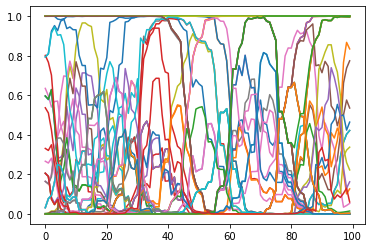

In [20]:
plt.plot(network.nodes)